In [1]:
#import some important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
#import the databases
sdf = pd.read_csv('SAMPL.csv')
sdf.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


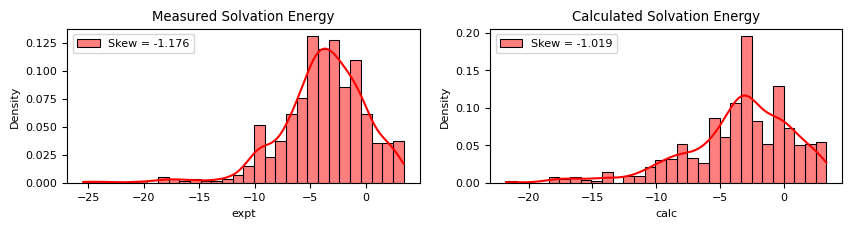

In [3]:
# the distribution of solvation energy  
plt.figure(figsize=(10, 2))
plt.rc('font', size=8)  

plt.subplot(1, 2, 1)
skew=sdf['expt'].skew()
sns.histplot(sdf['expt'], kde=True, stat="density", label='Skew = %.3f' %(skew), 
             bins=30, color='r')
plt.legend(loc='best')
plt.title('Measured Solvation Energy')

plt.subplot(1, 2, 2)
skew=sdf['calc'].skew()
sns.histplot(sdf['calc'], kde=True, stat="density", label='Skew = %.3f' %(skew), 
             bins=30, color='r')
plt.legend(loc='best')
plt.title('Calculated Solvation Energy')
plt.show()


In [4]:
# import library
from rdkit.Chem import PandasTools
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scikit_mol.descriptors import MolecularDescriptorTransformer
from scikit_mol.conversions import SmilesToMolTransformer
from scikit_mol.fingerprints import RDKitFingerprintTransformer


In [5]:
# generate and loading mols
PandasTools.AddMoleculeColumnToFrame(sdf, smilesCol="smiles")
print(f"{sdf.ROMol.isna().sum()} out of {len(sdf)} SMILES failed in conversion")
print(sdf.shape)
sdf.head()

0 out of 642 SMILES failed in conversion
(642, 5)


,iupac,smiles,expt,calc,ROMol
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,<rdkit.Chem.rdchem.Mol object at 0x751bd0484430>
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,<rdkit.Chem.rdchem.Mol object at 0x751bd0484580>
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,<rdkit.Chem.rdchem.Mol object at 0x751bd04845f0>
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,<rdkit.Chem.rdchem.Mol object at 0x751bd0484660>
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,<rdkit.Chem.rdchem.Mol object at 0x751bd04846d0>


In [6]:
# train and test dataset with experimental solubility
X_train, X_test, y_train, y_test = train_test_split(
    sdf.ROMol, sdf.expt,test_size=0.2, random_state=42, )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((513,), (129,), (513,), (129,))

In [7]:
descriptor_calculator = MolecularDescriptorTransformer(desc_list=[
    "MolWt",                   # Molecular Weight
    "BalabanJ",                # Balaban's J index
    "NumRotatableBonds",       # Number of rotatable bonds
    "NumHDonors",              # Number of hydrogen bond donors
    "NumHAcceptors",           # Number of hydrogen bond acceptors
    "TPSA",                    # Topological Polar Surface Area
    "MolLogP",                 # LogP (octanol-water partition coefficient)
    "LabuteASA",               # Labute's Approximate Surface Area
    "PEOE_VSA1",               # PEOE-based VSA descriptor (low partial charge surface area)
    "PEOE_VSA2",               # PEOE-based VSA descriptor (high partial charge surface area)
    "NumAromaticRings",        # Number of aromatic rings
    "fr_halogen",              # Number of halogen atoms
    "fr_Al_OH",                # Number of hydroxyl groups (aliphatic)
    "fr_C_O",                  # Number of carbonyl groups
    "fr_amide",                # Number of amide groups
])
descriptor_calculator

MolecularDescriptorTransformer(desc_list=['MolWt', 'BalabanJ',
                                          'NumRotatableBonds', 'NumHDonors',
                                          'NumHAcceptors', 'TPSA', 'MolLogP',
                                          'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA2',
                                          'NumAromaticRings', 'fr_halogen',
                                          'fr_Al_OH', 'fr_C_O', 'fr_amide'])

In [8]:
desc_pipeline = make_pipeline(descriptor_calculator, PolynomialFeatures(degree=2))
desc_pipeline

Pipeline(steps=[('moleculardescriptortransformer',
                 MolecularDescriptorTransformer(desc_list=['MolWt', 'BalabanJ',
                                                           'NumRotatableBonds',
                                                           'NumHDonors',
                                                           'NumHAcceptors',
                                                           'TPSA', 'MolLogP',
                                                           'LabuteASA',
                                                           'PEOE_VSA1',
                                                           'PEOE_VSA2',
                                                           'NumAromaticRings',
                                                           'fr_halogen',
                                                           'fr_Al_OH', 'fr_C_O',
                                                           'fr_amide'])),
                ('polynomialfeatures', PolynomialFeatures())])

In [9]:
fingerprinter = RDKitFingerprintTransformer()
fingerprinter

RDKitFingerprintTransformer()

In [10]:
features_pipeline = make_union(desc_pipeline, fingerprinter)
features_pipeline

FeatureUnion(transformer_list=[('pipeline',
                                Pipeline(steps=[('moleculardescriptortransformer',
                                                 MolecularDescriptorTransformer(desc_list=['MolWt',
                                                                                           'BalabanJ',
                                                                                           'NumRotatableBonds',
                                                                                           'NumHDonors',
                                                                                           'NumHAcceptors',
                                                                                           'TPSA',
                                                                                           'MolLogP',
                                                                                           'LabuteASA',
                                                                                           'PEOE_VSA1',
                                                                                           'PEOE_VSA2',
                                                                                           'NumAromaticRings',
                                                                                           'fr_halogen',
                                                                                           'fr_Al_OH',
                                                                                           'fr_C_O',
                                                                                           'fr_amide'])),
                                                ('polynomialfeatures',
                                                 PolynomialFeatures())])),
                               ('rdkitfingerprinttransformer',
                                RDKitFingerprintTransformer())])

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
estimator = RandomForestRegressor(n_estimators=500,max_depth=100,min_samples_split=5)
model = make_pipeline(features_pipeline, estimator)
model

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('moleculardescriptortransformer',
                                                                  MolecularDescriptorTransformer(desc_list=['MolWt',
                                                                                                            'BalabanJ',
                                                                                                            'NumRotatableBonds',
                                                                                                            'NumHDonors',
                                                                                                            'NumHAcceptors',
                                                                                                            'TPSA',
                                                                                                            'MolLogP',
                                                                                                            'LabuteASA',
                                                                                                            'PEOE_VSA1',
                                                                                                            'PEOE_VSA2',
                                                                                                            'NumAromaticRings',
                                                                                                            'fr_halogen',
                                                                                                            'fr_Al_OH',
                                                                                                            'fr_C_O',
                                                                                                            'fr_amide'])),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures())])),
                                                ('rdkitfingerprinttransformer',
                                                 RDKitFingerprintTransformer())])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_split=5,
                                       n_estimators=500))])

In [13]:
model.fit(X_train, y_train)

print(f"Train score is {model.score(X_train, y_train)}")
print(f"Test score is {model.score(X_test, y_test)}")

Train score is 0.9772521464799309
Test score is 0.9398055729122617


In [14]:
# Predictions
y_test_pred = model.predict(X_test)

# Metrics
correlation = np.corrcoef(y_test_pred, y_test)[0, 1]
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

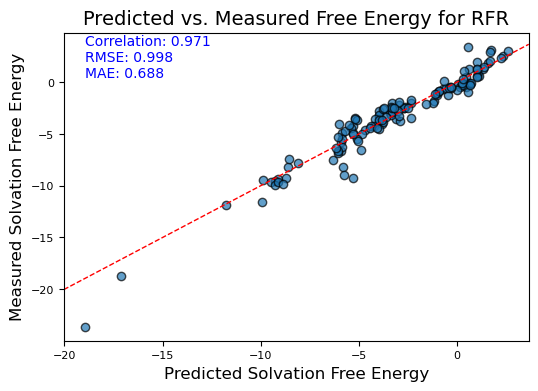

In [15]:
# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred, y_test, alpha=0.7, edgecolors='k')
plt.xlabel('Predicted Solvation Free Energy', fontsize=12)
plt.ylabel('Measured Solvation Free Energy', fontsize=12)
plt.title(f'Predicted vs. Measured Free Energy for RFR', fontsize=14)
plt.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1)
plt.text(min(y_test_pred), max(y_test)-3, f"Correlation: {correlation:.3f}\nRMSE: {test_rmse:.3f}\nMAE: {test_mae:.3f}", 
             fontsize=10, color='blue')
plt.savefig("rfr.png",dpi = 600)
plt.show()    

In [16]:
estimator2 =XGBRegressor(n_estimators=500,max_depth=100,gamma = 5,learning_rate = 0.01)
model2 = make_pipeline(features_pipeline, estimator2)
model2

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('moleculardescriptortransformer',
                                                                  MolecularDescriptorTransformer(desc_list=['MolWt',
                                                                                                            'BalabanJ',
                                                                                                            'NumRotatableBonds',
                                                                                                            'NumHDonors',
                                                                                                            'NumHAcceptors',
                                                                                                            'TPSA',
                                                                                                            'MolLogP',
                                                                                                            'LabuteASA',
                                                                                                            'PEOE_VSA1',
                                                                                                            'PEOE_VSA2',
                                                                                                            'NumAromaticRings',
                                                                                                            'fr_halogen',
                                                                                                            'fr_Al_OH',
                                                                                                            'fr_C_O',
                                                                                                            'fr_amide'...
                              feature_types=None, gamma=5, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=100, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [17]:
model2.fit(X_train, y_train)

print(f"Train score is {model2.score(X_train, y_train)}")
print(f"Test score is {model2.score(X_test, y_test)}")

Train score is 0.9764236133031898
Test score is 0.9396115300402439


In [21]:
# Predictions
y_test_pred2 = model2.predict(X_test)

# Metrics
correlation2 = np.corrcoef(y_test_pred2, y_test)[0, 1]
test_rmse2 = np.sqrt(mean_squared_error(y_test, y_test_pred2))
test_mae2 = mean_absolute_error(y_test, y_test_pred2)

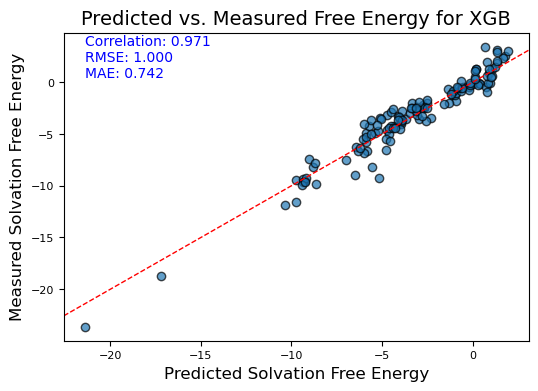

In [22]:
# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred2, y_test, alpha=0.7, edgecolors='k')
plt.xlabel('Predicted Solvation Free Energy', fontsize=12)
plt.ylabel('Measured Solvation Free Energy', fontsize=12)
plt.title(f'Predicted vs. Measured Free Energy for XGB', fontsize=14)
plt.axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1)
plt.text(min(y_test_pred2), max(y_test)-3, f"Correlation: {correlation2:.3f}\nRMSE: {test_rmse2:.3f}\nMAE: {test_mae2:.3f}", 
             fontsize=10, color='blue')
plt.savefig("xgb.png",dpi =600)
plt.show()  

## Solubility prediction
